In [1]:
!pip install  plotly_express
!pip install nbconvert
!pip install -U notebook-as-pdf

In [2]:
import requests
import geopy
import time
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly 
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
# empty list to place our data for each page
lst = []
API_KEY = "XhwAXVpj3nrNgikNQREOaW4XXyVvMBwQV_9L9mKp-kIawTch1UpoXOBhWPTr9Qnvar-FCz_8u4Dic3DMDXIy1o69Mm-Tj-hEFtTo5x84wY8YxxXjFhlVn4K9CFfjZXYx"
# our offset parameter - each page 50 rows
offset = 0
print('initial offset number: {}'.format(offset))

# loop through the api 20 times (limit is 1000 rows with each page includes 50 rows)
for i in range(20):
    
    try:
        headers = {'Authorization': 'Bearer {}'.format(API_KEY)}
        search_api_url = 'https://api.yelp.com/v3/businesses/search'
        params = {'term': 'food', 
                  'categories': 'restaurants',
                  'location': 'Texas', #If we will change here we can do the project on a different city
                  'offset': offset,
                  'limit': 50}

        response = requests.get(search_api_url, 
                                headers=headers, 
                                params=params, 
                                timeout=10)

        # return a dictionary
        data_dict = response.json()
        
        # convert the business dictionary to a pandas dataframe and append to list
        data = pd.DataFrame(data_dict['businesses'])
        lst.append(data)
      
        # add 50 to the offset to access a new page
        offset += 50
        print('current offset number: {}'.format(offset))
        
    except Exception as ex:
        print('exception: {}\nexit loop.'.format(ex))
        break

# concatenate all pages to one dataframe and reset index
df = pd.concat(lst)
df = df.reset_index(drop=True)

# review shape of dataframe
rows, columns = df.shape
print()
print('query includes {:,} rows and {} columns.'.format(rows, columns))
print('row id is unique: {}.'.format(df['id'].is_unique))

# review if dataframe id is unique, if not drop duplicates
if df['id'].is_unique == False:
    duplicates = df.loc[df.duplicated(subset=['id'])]
    vals = list(duplicates.head()['name'].values)
    print('\nduplicates found: {}.'.format(vals))
    
    df = df.drop_duplicates(subset=['id']).reset_index(drop=True)
    print('dropping duplicates...')
    
    rows, columns = df.shape
    print('\nrow id is unique: {}.'.format(df['id'].is_unique))
    print('query includes {:,} rows and {} columns.'.format(rows, columns))



initial offset number: 0
current offset number: 50
current offset number: 100
current offset number: 150
current offset number: 200
current offset number: 250
current offset number: 300
current offset number: 350
current offset number: 400
current offset number: 450
current offset number: 500
current offset number: 550
current offset number: 600
current offset number: 650
current offset number: 700
current offset number: 750
current offset number: 800
current offset number: 850
current offset number: 900
current offset number: 950
current offset number: 1000

query includes 1,000 rows and 16 columns.
row id is unique: True.


In [4]:
df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,NNMvUp-r7sQt7Q2l-kO9wA,the-breakfast-klub-houston-2,The Breakfast Klub,https://s3-media4.fl.yelpcdn.com/bphoto/g8NDOI...,False,https://www.yelp.com/biz/the-breakfast-klub-ho...,6092,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,"{'latitude': 29.73843, 'longitude': -95.38048}","[pickup, delivery]",$$,"{'address1': '3711 Travis St', 'address2': '',...",+17135288561,(713) 528-8561,3370.053899
1,MuqrcFUxtovR-0Z4rlSwwg,space-city-birria-houston,Space City Birria,https://s3-media2.fl.yelpcdn.com/bphoto/V3Uh6j...,False,https://www.yelp.com/biz/space-city-birria-hou...,177,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.6,"{'latitude': 29.7623351, 'longitude': -95.3630...","[pickup, restaurant_reservation, delivery]",$$,"{'address1': '415 Milam St', 'address2': None,...",+18328027333,(832) 802-7333,355.968253
2,xdx57Qj1FJi0MK8kwzbeuA,la-calle-tacos-houston-16,La Calle Tacos,https://s3-media4.fl.yelpcdn.com/bphoto/kBz7FT...,False,https://www.yelp.com/biz/la-calle-tacos-housto...,1153,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.0,"{'latitude': 29.7634662971423, 'longitude': -9...","[pickup, delivery]",$$,"{'address1': '909 Franklin St', 'address2': ''...",+18327358226,(832) 735-8226,86.248358
3,RoU8KznQMrRFcIjYVtdZMw,the-pit-room-houston,The Pit Room,https://s3-media3.fl.yelpcdn.com/bphoto/KkligA...,False,https://www.yelp.com/biz/the-pit-room-houston?...,2907,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...",4.3,"{'latitude': 29.7342352703345, 'longitude': -9...","[pickup, delivery]",$$,"{'address1': '1201 Richmond Ave', 'address2': ...",+12818881929,(281) 888-1929,4585.949511
4,n8MvjjhuUg8NAQKinUASHw,underground-hall-houston,Underground Hall,https://s3-media3.fl.yelpcdn.com/bphoto/feu0KK...,False,https://www.yelp.com/biz/underground-hall-hous...,132,"[{'alias': 'food_court', 'title': 'Food Court'...",4.4,"{'latitude': 29.76038, 'longitude': -95.36162}",[delivery],$$,"{'address1': '1010 Prairie St', 'address2': No...",+12818884323,(281) 888-4323,351.703073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,AT2IWY-70qZ9EhRHgRvOQQ,home-slice-pizza-houston,Home Slice Pizza,https://s3-media3.fl.yelpcdn.com/bphoto/UnhJTF...,False,https://www.yelp.com/biz/home-slice-pizza-hous...,167,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.1,"{'latitude': 29.738738307329143, 'longitude': ...",[pickup],NaN,"{'address1': '3701 Travis St', 'address2': '',...",+18328107437,(832) 810-7437,3333.277525
996,wx04B4PXjw2x2_Gutu-6ww,doña-chela-restaurant-houston-2,Doña Chela Restaurant,https://s3-media3.fl.yelpcdn.com/bphoto/qfkSLz...,False,https://www.yelp.com/biz/do%C3%B1a-chela-resta...,27,"[{'alias': 'mexican', 'title': 'Mexican'}]",4.3,"{'latitude': 29.73911, 'longitude': -95.28693}",[pickup],$,"{'address1': '1112 76th St', 'address2': None,...",+17139236400,(713) 923-6400,7532.550604
997,mc74laKbcmWkNkUzeNyXxg,lotus-seafood-and-wings-houston,Lotus Seafood & Wings,https://s3-media3.fl.yelpcdn.com/bphoto/j1cbLx...,False,https://www.yelp.com/biz/lotus-seafood-and-win...,361,"[{'alias': 'chicken_wings', 'title': 'Chicken ...",3.3,"{'latitude': 29.91421886175354, 'longitude': -...",[delivery],$$,"{'address1': '10092 Veterans Memorial Dr', 'ad...",+12814478881,(281) 447-8881,18533.373729
998,FyAsEsVimKwy4PK1H-D4iQ,manna-noodle-house-houston,Manna Noodle House,https://s3-media1.fl.yelpcdn.com/bphoto/Ki81Ji...,False,https://www.yelp.com/biz/manna-noodle-house-ho...,145,"[{'alias': 'korean', 'title': 'Korean'}, {'ali...",4.4,"{'latitude': 29.793971, 'longitude': -95.536406}",[delivery],$$,"{'address1': '9887 Long Point Rd', 'address2':...",+17134676965,(713) 467-6965,17373.765152


In [5]:
# Export DataFrame to CSV
df.to_csv("Yelp_Restaurant.csv")
# Read the CSV file
df_read = pd.read_csv('Yelp_Restaurant.csv')

# Cleaning The Data #
## and adding some features ##

In [6]:
df[["latitude","longitude"]] = df["coordinates"].apply(pd.Series)

max_num_addresses = df['location'].apply(lambda x: len(x) if isinstance(x, dict) else 0).max()

for i in range(1, max_num_addresses + 1):
    col_name = f'address_{i}'
    df[col_name] = df['location'].apply(lambda x: x.get(f'address{i}', None) if isinstance(x, dict) else None)

df = df.drop(columns=['coordinates'])

none_count = df.isna().sum()
print(none_count)

# Remove columns 'address_4', 'address_5', 'address_6', 'address_7', 'address_8' if they exist
columns_to_drop = [f'address_{i}' for i in range(4, 9)]
df = df.drop(columns=columns_to_drop, errors='ignore')

df.head()


id                  0
alias               0
name                0
image_url           0
is_closed           0
url                 0
review_count        0
categories          0
rating              0
transactions        0
price             342
location            0
phone               0
display_phone       0
distance            0
latitude            0
longitude           0
address_1          10
address_2         246
address_3         464
address_4        1000
address_5        1000
address_6        1000
address_7        1000
address_8        1000
dtype: int64


,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,price,location,phone,display_phone,distance,latitude,longitude,address_1,address_2,address_3
0,NNMvUp-r7sQt7Q2l-kO9wA,the-breakfast-klub-houston-2,The Breakfast Klub,https://s3-media4.fl.yelpcdn.com/bphoto/g8NDOI...,False,https://www.yelp.com/biz/the-breakfast-klub-ho...,6092,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,"[pickup, delivery]",$$,"{'address1': '3711 Travis St', 'address2': '',...",+17135288561,(713) 528-8561,3370.053899,29.738430,-95.380480,3711 Travis St,,
1,MuqrcFUxtovR-0Z4rlSwwg,space-city-birria-houston,Space City Birria,https://s3-media2.fl.yelpcdn.com/bphoto/V3Uh6j...,False,https://www.yelp.com/biz/space-city-birria-hou...,177,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.6,"[pickup, restaurant_reservation, delivery]",$$,"{'address1': '415 Milam St', 'address2': None,...",+18328027333,(832) 802-7333,355.968253,29.762335,-95.363033,415 Milam St,None,None
2,xdx57Qj1FJi0MK8kwzbeuA,la-calle-tacos-houston-16,La Calle Tacos,https://s3-media4.fl.yelpcdn.com/bphoto/kBz7FT...,False,https://www.yelp.com/biz/la-calle-tacos-housto...,1153,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.0,"[pickup, delivery]",$$,"{'address1': '909 Franklin St', 'address2': ''...",+18327358226,(832) 735-8226,86.248358,29.763466,-95.360690,909 Franklin St,,
3,RoU8KznQMrRFcIjYVtdZMw,the-pit-room-houston,The Pit Room,https://s3-media3.fl.yelpcdn.com/bphoto/KkligA...,False,https://www.yelp.com/biz/the-pit-room-houston?...,2907,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...",4.3,"[pickup, delivery]",$$,"{'address1': '1201 Richmond Ave', 'address2': ...",+12818881929,(281) 888-1929,4585.949511,29.734235,-95.393968,1201 Richmond Ave,,
4,n8MvjjhuUg8NAQKinUASHw,underground-hall-houston,Underground Hall,https://s3-media3.fl.yelpcdn.com/bphoto/feu0KK...,False,https://www.yelp.com/biz/underground-hall-hous...,132,"[{'alias': 'food_court', 'title': 'Food Court'...",4.4,[delivery],$$,"{'address1': '1010 Prairie St', 'address2': No...",+12818884323,(281) 888-4323,351.703073,29.760380,-95.361620,1010 Prairie St,None,


In [7]:
df.dtypes
df['is_closed'] = (df['is_closed'] == False).astype(int)
df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,price,location,phone,display_phone,distance,latitude,longitude,address_1,address_2,address_3
0,NNMvUp-r7sQt7Q2l-kO9wA,the-breakfast-klub-houston-2,The Breakfast Klub,https://s3-media4.fl.yelpcdn.com/bphoto/g8NDOI...,1,https://www.yelp.com/biz/the-breakfast-klub-ho...,6092,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,"[pickup, delivery]",$$,"{'address1': '3711 Travis St', 'address2': '',...",+17135288561,(713) 528-8561,3370.053899,29.738430,-95.380480,3711 Travis St,,
1,MuqrcFUxtovR-0Z4rlSwwg,space-city-birria-houston,Space City Birria,https://s3-media2.fl.yelpcdn.com/bphoto/V3Uh6j...,1,https://www.yelp.com/biz/space-city-birria-hou...,177,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.6,"[pickup, restaurant_reservation, delivery]",$$,"{'address1': '415 Milam St', 'address2': None,...",+18328027333,(832) 802-7333,355.968253,29.762335,-95.363033,415 Milam St,None,None
2,xdx57Qj1FJi0MK8kwzbeuA,la-calle-tacos-houston-16,La Calle Tacos,https://s3-media4.fl.yelpcdn.com/bphoto/kBz7FT...,1,https://www.yelp.com/biz/la-calle-tacos-housto...,1153,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.0,"[pickup, delivery]",$$,"{'address1': '909 Franklin St', 'address2': ''...",+18327358226,(832) 735-8226,86.248358,29.763466,-95.360690,909 Franklin St,,
3,RoU8KznQMrRFcIjYVtdZMw,the-pit-room-houston,The Pit Room,https://s3-media3.fl.yelpcdn.com/bphoto/KkligA...,1,https://www.yelp.com/biz/the-pit-room-houston?...,2907,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...",4.3,"[pickup, delivery]",$$,"{'address1': '1201 Richmond Ave', 'address2': ...",+12818881929,(281) 888-1929,4585.949511,29.734235,-95.393968,1201 Richmond Ave,,
4,n8MvjjhuUg8NAQKinUASHw,underground-hall-houston,Underground Hall,https://s3-media3.fl.yelpcdn.com/bphoto/feu0KK...,1,https://www.yelp.com/biz/underground-hall-hous...,132,"[{'alias': 'food_court', 'title': 'Food Court'...",4.4,[delivery],$$,"{'address1': '1010 Prairie St', 'address2': No...",+12818884323,(281) 888-4323,351.703073,29.760380,-95.361620,1010 Prairie St,None,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,AT2IWY-70qZ9EhRHgRvOQQ,home-slice-pizza-houston,Home Slice Pizza,https://s3-media3.fl.yelpcdn.com/bphoto/UnhJTF...,1,https://www.yelp.com/biz/home-slice-pizza-hous...,167,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.1,[pickup],NaN,"{'address1': '3701 Travis St', 'address2': '',...",+18328107437,(832) 810-7437,3333.277525,29.738738,-95.380193,3701 Travis St,,None
996,wx04B4PXjw2x2_Gutu-6ww,doña-chela-restaurant-houston-2,Doña Chela Restaurant,https://s3-media3.fl.yelpcdn.com/bphoto/qfkSLz...,1,https://www.yelp.com/biz/do%C3%B1a-chela-resta...,27,"[{'alias': 'mexican', 'title': 'Mexican'}]",4.3,[pickup],$,"{'address1': '1112 76th St', 'address2': None,...",+17139236400,(713) 923-6400,7532.550604,29.739110,-95.286930,1112 76th St,None,None
997,mc74laKbcmWkNkUzeNyXxg,lotus-seafood-and-wings-houston,Lotus Seafood & Wings,https://s3-media3.fl.yelpcdn.com/bphoto/j1cbLx...,1,https://www.yelp.com/biz/lotus-seafood-and-win...,361,"[{'alias': 'chicken_wings', 'title': 'Chicken ...",3.3,[delivery],$$,"{'address1': '10092 Veterans Memorial Dr', 'ad...",+12814478881,(281) 447-8881,18533.373729,29.914219,-95.440827,10092 Veterans Memorial Dr,Ste B,
998,FyAsEsVimKwy4PK1H-D4iQ,manna-noodle-house-houston,Manna Noodle House,https://s3-media1.fl.yelpcdn.com/bphoto/Ki81Ji...,1,https://www.yelp.com/biz/manna-noodle-house-ho...,145,"[{'alias': 'korean', 'title': 'Korean'}, {'ali...",4.4,[delivery],$$,"{'address1': '9887 Long Point Rd', 'address2':...",+17134676965,(713) 467-6965,17373.765152,29.793971,-95.536406,9887 Long Point Rd,,


## Visualizations ##

In [8]:
top_restaurants = df.sort_values(by=['review_count', 'rating'], ascending=False)[:10]
top_restaurants.head(10)


,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,price,location,phone,display_phone,distance,latitude,longitude,address_1,address_2,address_3
0,NNMvUp-r7sQt7Q2l-kO9wA,the-breakfast-klub-houston-2,The Breakfast Klub,https://s3-media4.fl.yelpcdn.com/bphoto/g8NDOI...,1,https://www.yelp.com/biz/the-breakfast-klub-ho...,6092,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,"[pickup, delivery]",$$,"{'address1': '3711 Travis St', 'address2': '',...",+17135288561,(713) 528-8561,3370.053899,29.738430,-95.380480,3711 Travis St,,
976,bRA-zzvte71rq5x45J7-zQ,taste-of-texas-houston,Taste of Texas,https://s3-media1.fl.yelpcdn.com/bphoto/MAvfDx...,1,https://www.yelp.com/biz/taste-of-texas-housto...,3723,"[{'alias': 'steak', 'title': 'Steakhouses'}, {...",4.5,"[pickup, delivery, restaurant_reservation]",$$$,"{'address1': '10505 Katy Fwy', 'address2': '',...",+17139326901,(713) 932-6901,19136.105106,29.782831,-95.556904,10505 Katy Fwy,,
104,MtrXTHsxOCw0iCtOlPhrGQ,jinya-ramen-bar-houston-houston,JINYA Ramen Bar - Houston,https://s3-media1.fl.yelpcdn.com/bphoto/0T33BB...,1,https://www.yelp.com/biz/jinya-ramen-bar-houst...,3529,"[{'alias': 'ramen', 'title': 'Ramen'}, {'alias...",4.3,"[delivery, pickup]",$$,"{'address1': '3201 Louisiana St', 'address2': ...",+18329258596,(832) 925-8596,2960.141681,29.742724,-95.379789,3201 Louisiana St,Ste 105,
707,haOLj8uMDwmZTNsJ7_HSjg,agas-restaurant-and-catering-houston-14,Aga's Restaurant & Catering,https://s3-media2.fl.yelpcdn.com/bphoto/3z_XIu...,1,https://www.yelp.com/biz/agas-restaurant-and-c...,2936,"[{'alias': 'indpak', 'title': 'Indian'}]",4.6,[delivery],$$,"{'address1': '11842 Wilcrest Dr', 'address2': ...",+18327868000,(832) 786-8000,23721.621589,29.649143,-95.567697,11842 Wilcrest Dr,,
3,RoU8KznQMrRFcIjYVtdZMw,the-pit-room-houston,The Pit Room,https://s3-media3.fl.yelpcdn.com/bphoto/KkligA...,1,https://www.yelp.com/biz/the-pit-room-houston?...,2907,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...",4.3,"[pickup, delivery]",$$,"{'address1': '1201 Richmond Ave', 'address2': ...",+12818881929,(281) 888-1929,4585.949511,29.734235,-95.393968,1201 Richmond Ave,,
175,1Xg9YJ6EcFKYdWCLyWwn1A,killens-barbecue-pearland-4,Killen's Barbecue,https://s3-media2.fl.yelpcdn.com/bphoto/i6bC4U...,1,https://www.yelp.com/biz/killens-barbecue-pear...,2815,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...",4.2,"[pickup, delivery]",$$,"{'address1': '3613 E Broadway', 'address2': ''...",+12814852272,(281) 485-2272,23365.076039,29.564033,-95.282281,3613 E Broadway,,
501,237MSviehmCzD_wwKg4-zA,bosscat-kitchen-and-libations-houston,Bosscat Kitchen & Libations,https://s3-media4.fl.yelpcdn.com/bphoto/CUsonA...,1,https://www.yelp.com/biz/bosscat-kitchen-and-l...,2763,"[{'alias': 'newamerican', 'title': 'New Americ...",4.3,"[pickup, delivery]",$$,"{'address1': '4310 Westheimer Rd', 'address2':...",+12815011187,(281) 501-1187,9068.955786,29.741800,-95.450518,4310 Westheimer Rd,Ste 150,None
255,NeTU3xFecz5vIeVWmd8LOw,dish-society-houston,Dish Society,https://s3-media2.fl.yelpcdn.com/bphoto/ANr_lx...,1,https://www.yelp.com/biz/dish-society-houston?...,2646,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.3,"[delivery, pickup]",$$,"{'address1': '5740 San Felipe St', 'address2':...",+18325381060,(832) 538-1060,11560.462512,29.750510,-95.478690,5740 San Felipe St,Ste 100,
165,sICvh8l9t31JcDgwweNe8A,turkey-leg-hut-houston-4,Turkey Leg Hut,https://s3-media2.fl.yelpcdn.com/bphoto/9zXTef...,1,https://www.yelp.com/biz/turkey-leg-hut-housto...,2601,"[{'alias': 'southern', 'title': 'Southern'}, {...",3.9,[delivery],$$,"{'address1': '4830 Almeda Rd', 'address2': 'St...",+18327870770,(832) 787-0770,4467.803118,29.725999,-95.377926,4830 Almeda Rd,Ste A-B,None
746,AAf5Mq-xpME2bkB1Z1auaQ,common-bond-bistro-and-bakery-montrose-houston,Common Bond Bistro & Bakery - Montrose,https://s3-media2.fl.yelpcdn.com/bphoto/hYGWp5...,1,https://www.yelp.com/biz/common-bond-bistro-an...,2432,"[{'alias': 'cafes', 'titl

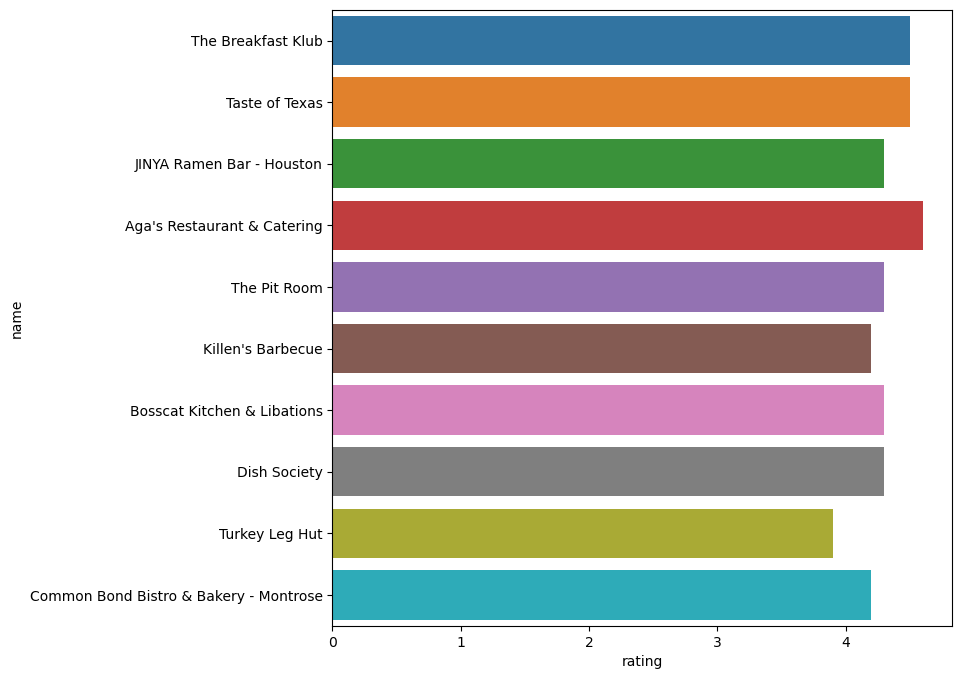

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x = 'rating', y = 'name', data=top_restaurants, ax= ax)
plt.show()

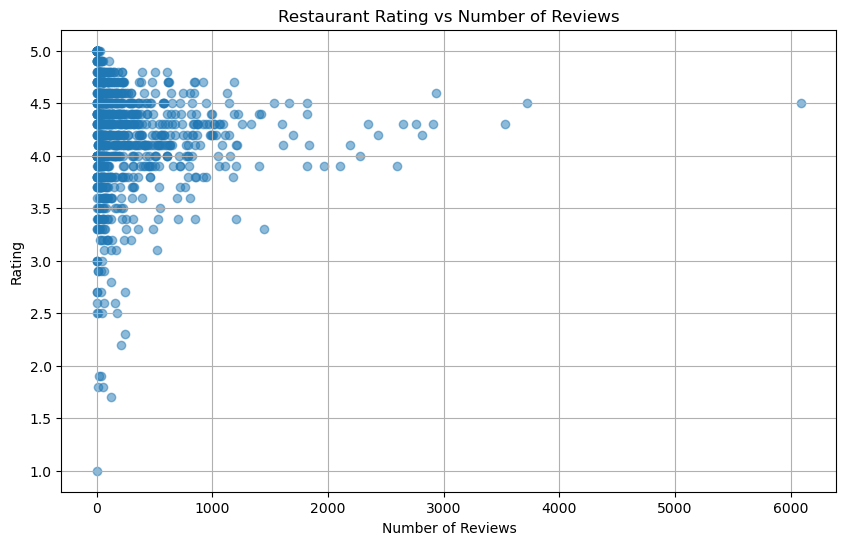

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(df['review_count'], df['rating'], alpha=0.5)
plt.title('Restaurant Rating vs Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

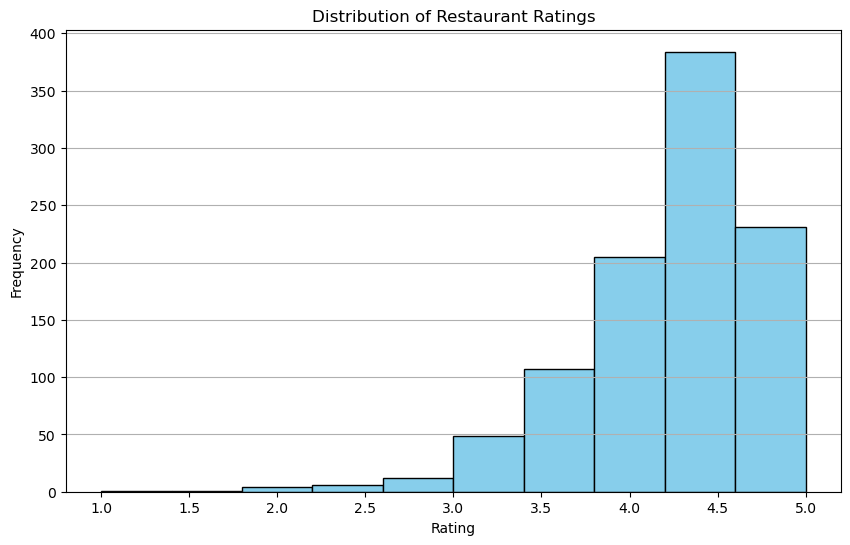

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

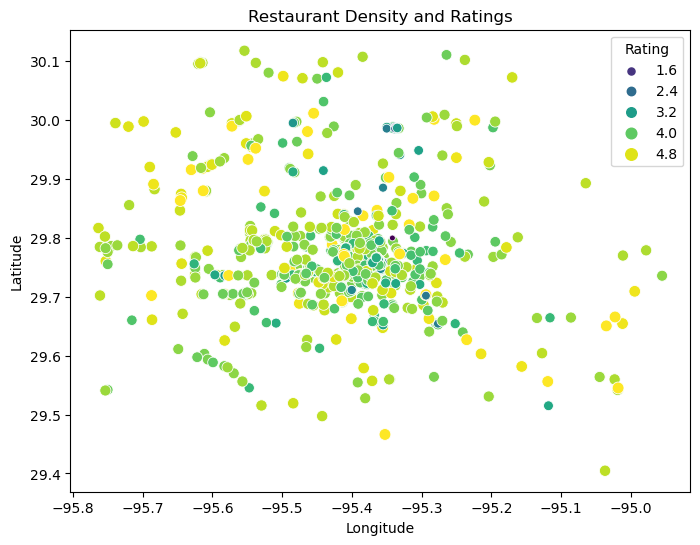

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', size='rating', data=df, hue='rating', palette='viridis')
plt.title('Restaurant Density and Ratings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Rating')
plt.show()

## Creating the Models ##

In [13]:
#Finding the optimal K for KNN
coords = df[['longitude','latitude']]

distortions = []

for k in range(1,25):
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)


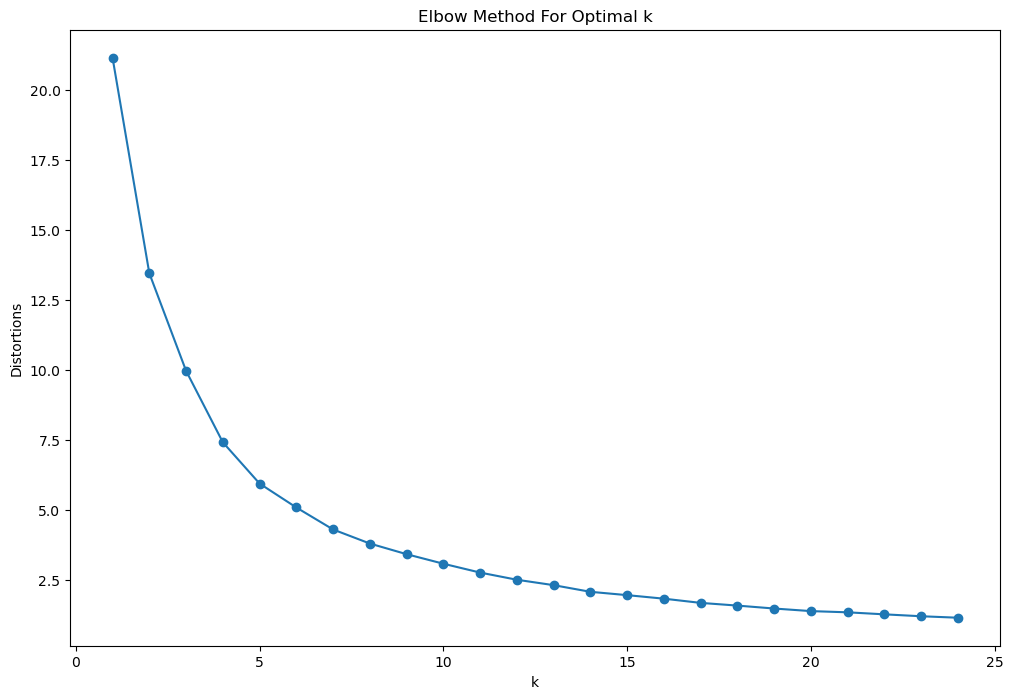

In [14]:
#Searching for the optimal K using the elbow method
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(range(1,25), distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
plt.show()

In [15]:
sil = []
kmax = 25

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coords)
  labels = kmeans.labels_
  sil.append(silhouette_score(coords, labels, metric = 'euclidean'))

In [16]:
sil

[0.5016724920205806,
 0.5021578607591535,
 0.5553923480119445,
 0.5469985229368174,
 0.4670395265548094,
 0.46413804655949364,
 0.4535126205152947,
 0.448085985760022,
 0.4032555830105315,
 0.42222886560958217,
 0.4153425856285648,
 0.42801880685755206,
 0.44375489038213406,
 0.4355318223527994,
 0.42178989536980077,
 0.445667573801166,
 0.41922294718007724,
 0.42775603008623514,
 0.42536956407026094,
 0.4400544835051713,
 0.42418244198739913,
 0.41447719750650297,
 0.41385406528677077,
 0.4237631680606745]

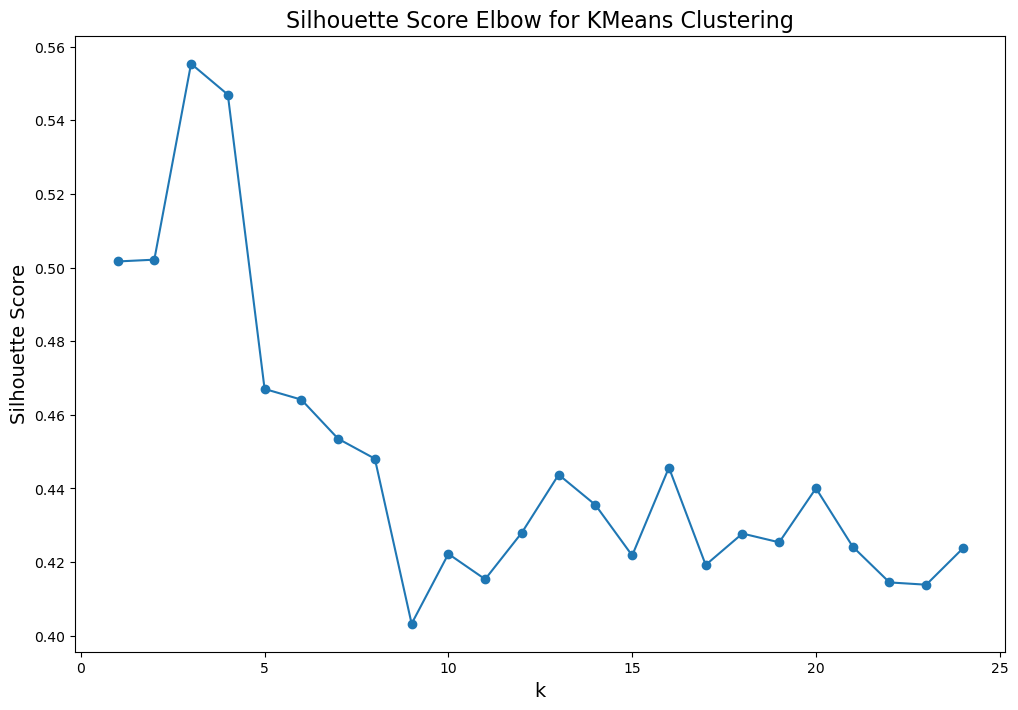

In [17]:
# Elbow Graph for Silhouette Score
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(range(1,25), sil[:24], marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Silhouette Score', fontsize = 14)
plt.title('Silhouette Score Elbow for KMeans Clustering', fontsize = 16)
plt.show()

In [18]:
#We set the number of clusters to 5 based on the elbow method for the optimal K. According to the sil elbow we suppose to have 3 clusters so we will do 4.
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(coords)
y = kmeans.labels_
print("k = 4", " silhouette_score ", silhouette_score(coords, y, metric='euclidean'))

k = 4  silhouette_score  0.5553923480119445


In [19]:
df['cluster'] = kmeans.predict(df[['longitude','latitude']])
df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,location,phone,display_phone,distance,latitude,longitude,address_1,address_2,address_3,cluster
0,NNMvUp-r7sQt7Q2l-kO9wA,the-breakfast-klub-houston-2,The Breakfast Klub,https://s3-media4.fl.yelpcdn.com/bphoto/g8NDOI...,1,https://www.yelp.com/biz/the-breakfast-klub-ho...,6092,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,"[pickup, delivery]",...,"{'address1': '3711 Travis St', 'address2': '',...",+17135288561,(713) 528-8561,3370.053899,29.738430,-95.380480,3711 Travis St,,,1
1,MuqrcFUxtovR-0Z4rlSwwg,space-city-birria-houston,Space City Birria,https://s3-media2.fl.yelpcdn.com/bphoto/V3Uh6j...,1,https://www.yelp.com/biz/space-city-birria-hou...,177,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.6,"[pickup, restaurant_reservation, delivery]",...,"{'address1': '415 Milam St', 'address2': None,...",+18328027333,(832) 802-7333,355.968253,29.762335,-95.363033,415 Milam St,None,None,1
2,xdx57Qj1FJi0MK8kwzbeuA,la-calle-tacos-houston-16,La Calle Tacos,https://s3-media4.fl.yelpcdn.com/bphoto/kBz7FT...,1,https://www.yelp.com/biz/la-calle-tacos-housto...,1153,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.0,"[pickup, delivery]",...,"{'address1': '909 Franklin St', 'address2': ''...",+18327358226,(832) 735-8226,86.248358,29.763466,-95.360690,909 Franklin St,,,1
3,RoU8KznQMrRFcIjYVtdZMw,the-pit-room-houston,The Pit Room,https://s3-media3.fl.yelpcdn.com/bphoto/KkligA...,1,https://www.yelp.com/biz/the-pit-room-houston?...,2907,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...",4.3,"[pickup, delivery]",...,"{'address1': '1201 Richmond Ave', 'address2': ...",+12818881929,(281) 888-1929,4585.949511,29.734235,-95.393968,1201 Richmond Ave,,,1
4,n8MvjjhuUg8NAQKinUASHw,underground-hall-houston,Underground Hall,https://s3-media3.fl.yelpcdn.com/bphoto/feu0KK...,1,https://www.yelp.com/biz/underground-hall-hous...,132,"[{'alias': 'food_court', 'title': 'Food Court'...",4.4,[delivery],...,"{'address1': '1010 Prairie St', 'address2': No...",+12818884323,(281) 888-4323,351.703073,29.760380,-95.361620,1010 Prairie St,None,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,AT2IWY-70qZ9EhRHgRvOQQ,home-slice-pizza-houston,Home Slice Pizza,https://s3-media3.fl.yelpcdn.com/bphoto/UnhJTF...,1,https://www.yelp.com/biz/home-slice-pizza-hous...,167,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.1,[pickup],...,"{'address1': '3701 Travis St', 'address2': '',...",+18328107437,(832) 810-7437,3333.277525,29.738738,-95.380193,3701 Travis St,,None,1
996,wx04B4PXjw2x2_Gutu-6ww,doña-chela-restaurant-houston-2,Doña Chela Restaurant,https://s3-media3.fl.yelpcdn.com/bphoto/qfkSLz...,1,https://www.yelp.com/biz/do%C3%B1a-chela-resta...,27,"[{'alias': 'mexican', 'title': 'Mexican'}]",4.3,[pickup],...,"{'address1': '1112 76th St', 'address2': None,...",+17139236400,(713) 923-6400,7532.550604,29.739110,-95.286930,1112 76th St,None,None,1
997,mc74laKbcmWkNkUzeNyXxg,lotus-seafood-and-wings-houston,Lotus Seafood & Wings,https://s3-media3.fl.yelpcdn.com/bphoto/j1cbLx...,1,https://www.yelp.com/biz/lotus-seafood-and-win...,361,"[{'alias': 'chicken_wings', 'title': 'Chicken ...",3.3,[delivery],...,"{'address1': '10092 Veterans Memorial Dr', 'ad...",+12814478881,(281) 447-8881,18533.373729,29.914219,-95.440827,10092 Veterans Memorial Dr,Ste B,,2
998,FyAsEsVimKwy4PK1H-D4iQ,manna-noodle-house-houston,Manna Noodle House,https://s3-media1.fl.yelpcdn.com/bphoto/Ki81Ji...,1,https://www.yelp.com/biz/manna-noodle-house-ho...,145,"[{'alias': 'korean', 'title': 'Korean'}, {'ali...",4.4,[delivery],...,"{'address1': '9887 Long Point Rd', 'address2':...",+17134676965,(713) 467-6965,17373.765152,29.793971,-95.536406,9887 Long Point Rd,,,0


In [20]:
def recommend_restaurants_k(df, longitude, latitude):
    start = time.time()

    # Predict the cluster for longitude and latitude provided
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print(cluster)
    end = time.time()
    print("Time until getting a result: ", end - start)
    # Get the best restaurant in this cluster
    return  df[df['cluster']==cluster].iloc[0:10][['name', 'latitude','longitude']]
recommend_restaurants_k(df, -95.4, 29.8)

1
Time until getting a result:  0.1716461181640625


,name,latitude,longitude
0,The Breakfast Klub,29.738430,-95.380480
1,Space City Birria,29.762335,-95.363033
2,La Calle Tacos,29.763466,-95.360690
3,The Pit Room,29.734235,-95.393968
4,Underground Hall,29.760380,-95.361620
5,Tumble 22,29.767900,-95.372638
6,Xeo Yum,29.746456,-95.377976
7,ChopnBlok,29.766140,-95.364880
8,Yoyo’s Hot Dogs,29.766230,-95.364891
9,The Signature Kafe,29.738357,-95.379786


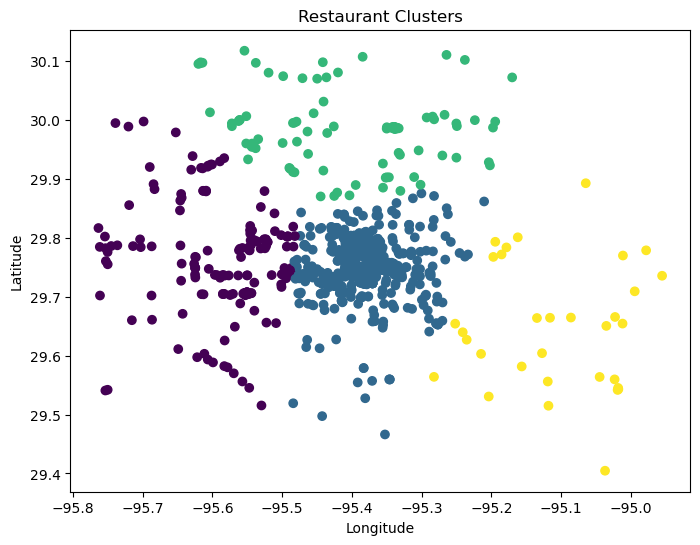

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Restaurant Clusters')
plt.show()

In [22]:
#Testing the  K-means model:
test_coordinates = {
    'user': [1, 2, 3], 
    'latitude' : [29.5, 	40.715434, 43],
    'longitude' : [-71, -173.922060, -71.85],
}

test_df = pd.DataFrame(test_coordinates)
test_df

,user,latitude,longitude
0,1,29.500000,-71.00000
1,2,40.715434,-173.92206
2,3,43.000000,-71.85000


In [23]:
user1 = test_df[test_df['user'] == 1]
user2 = test_df[test_df['user'] == 2]
user3 = test_df[test_df['user'] == 3]
recommend_restaurants_k(df, user1.longitude, user1.latitude)
#recommend_restaurants_k(df, user2.longitude, user2.latitude)
#recommend_restaurants_k(df, user3.longitude, user3.latitude)

3
Time until getting a result:  0.16378355026245117


,name,latitude,longitude
18,The Cuban Cafe,29.654470,-95.012010
86,Fish and Chips Houston,29.543082,-95.018019
139,Broke Da Mouth Treats,29.530695,-95.203793
175,Killen's Barbecue,29.564033,-95.282281
180,The Cuban Cafe - Baytown,29.770007,-95.011461
193,Asha's Roti Shop,29.735680,-94.955320
224,Noodle Master,29.663942,-95.134692
407,The Backyard,29.559760,-95.023370
517,Birrieria El Compadre,29.603056,-95.214812
549,Eculent,29.541840,-95.019040


In [24]:
#In this part we will check restaurants from one of the clusters and figure out which restaurants in the same cluster are the most recommended

In [25]:
#DBSCAN Method

# Select relevant features for clustering
X = df[['rating', 'latitude', 'longitude']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=2)
df['cluster'] = dbscan.fit_predict(X_scaled)


In [26]:
def recommend_restaurants_db(df, longitude, latitude):
    # Predict the cluster for longitude and latitude provided
    start =time.time()
    cluster = dbscan.fit_predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print(cluster)
    end = time.time()
    print("Time until getting a result: ", end - start)
    # Get the best restaurant in this cluster
    return df[df['cluster']==cluster].iloc[0:10][['name', 'latitude','longitude']]


In [27]:
recommend_restaurants_db(df, user1.longitude, user1.latitude)
#recommend_restaurants_db(df, user2.longitude, user2.latitude)
#recommend_restaurants_db(df, user3.longitude, user3.latitude)

-1
Time until getting a result:  0.0025517940521240234


,name,latitude,longitude
16,Mom's Country Kitchen,29.926128,-95.355486
19,AZTECA Taco House,29.879736,-95.330429
43,Red’s Kitchen,29.647412,-95.355838
51,Stone Age Street Food,29.705436,-95.546444
71,Porky's Backyard,29.987229,-95.197699
76,The Original Kolache Shoppe,29.685915,-95.297190
99,Cup N Char,29.661013,-95.686417
109,House of Fries,29.843105,-95.472766
116,Da Food Plug Htx,30.001245,-95.282083
117,Chicharrones El Guero,29.771840,-95.233550


In [28]:
def calculate_silhouette_score(df, eps, min_samples):
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(df)

    silhouette = silhouette_score(df, labels)
    return silhouette

X = df[['rating', 'latitude', 'longitude']]
calculate_silhouette_score(X, 0.3, 2)

0.7400251593816992

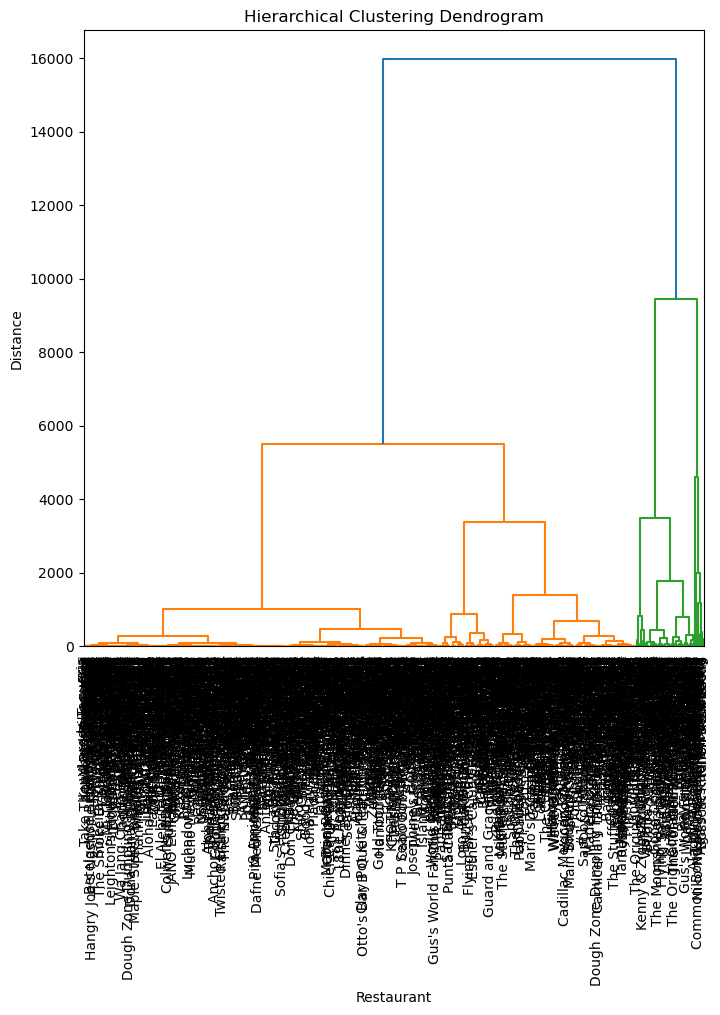

In [29]:
#Not sure if heirarchial clustering fits in this problem but lets do it anyway

# Select relevant features for clustering
X = df[['rating', 'review_count', 'longitude', 'latitude']]

# Perform hierarchical clustering
Z = linkage(X, method='ward', metric='euclidean')

# Plot dendrogram
plt.figure(figsize=(8, 8))
dendrogram(Z, labels=df['name'].values, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Restaurant')
plt.ylabel('Distance')
plt.show()

In [30]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import cdist

def predict_location_cluster(locations, new_location, k=3):
   
    # Select relevant features for clustering
    X = locations[['latitude', 'longitude']].to_numpy()

    # Perform hierarchical clustering
    Z = linkage(X, method='ward')

    # Assign clusters to data points
    clusters = fcluster(Z, k, criterion='maxclust')

    # Calculate distances to cluster centroids
    centroids = np.array([np.mean(X[clusters == i], axis=0) for i in range(1, k+1)])
    distances = cdist(np.array([new_location]), centroids)

    silhoette_avg = silhouette_score(X, clusters)
    print("The silhouette score is: ", silhoette_avg)
    # Predict cluster for new location
    predicted_cluster = np.argmin(distances) + 1  # +1 because cluster indexing starts from 1

    return predicted_cluster

In [31]:
new_location = [29.0, -95.0]  # Example new location

# Predict the cluster for the new location
predicted_cluster = predict_location_cluster(df, new_location)
print(predicted_cluster)
print("The new location is predicted to be in cluster", predicted_cluster)

suggest_cl = df[df["cluster"] == predicted_cluster].sort_values(by=['review_count', 'rating'], ascending=False)[:10]
suggest_cl

The silhouette score is:  0.444907352569088
1
The new location is predicted to be in cluster 1


,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,location,phone,display_phone,distance,latitude,longitude,address_1,address_2,address_3,cluster
18,D_yMrUddfD9aJA3BE7T1hw,the-cuban-cafe-la-porte,The Cuban Cafe,https://s3-media2.fl.yelpcdn.com/bphoto/_hycHh...,1,https://www.yelp.com/biz/the-cuban-cafe-la-por...,24,"[{'alias': 'cuban', 'title': 'Cuban'}, {'alias...",4.9,"[pickup, delivery]",...,"{'address1': '708 Park Dr', 'address2': '', 'a...",+12819414424,(281) 941-4424,35715.917308,29.654470,-95.012010,708 Park Dr,,None,1
876,EO5UTVEGq6Fo32pQi3h-Mg,mels-germarican-imbiss-la-porte,Mels Germarican Imbiss,https://s3-media3.fl.yelpcdn.com/bphoto/1WPohD...,1,https://www.yelp.com/biz/mels-germarican-imbis...,2,"[{'alias': 'newamerican', 'title': 'New Americ...",5.0,[],...,"{'address1': '1201 S 16th St', 'address2': Non...",+18327666142,(832) 766-6142,33763.786819,29.650559,-95.035271,1201 S 16th St,None,None,1
848,zsY3OrfW1r76vziIUagF9w,be-calm-be-cool-eats-la-porte-2,Be Calm Be Cool Eats,https://s3-media1.fl.yelpcdn.com/bphoto/RJ4-G8...,1,https://www.yelp.com/biz/be-calm-be-cool-eats-...,1,"[{'alias': 'puertorican', 'title': 'Puerto Ric...",5.0,"[pickup, delivery]",...,"{'address1': '402 W Main St', 'address2': '', ...",,,34332.817221,29.665700,-95.022740,402 W Main St,,None,1


In [32]:
!pip freeze > requirements.txt